<a href="https://colab.research.google.com/github/Pengyu-gis/Historical-Aerial-Photos/blob/main/faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchgeo rasterio

In [ ]:
import os
import torch
from torch.utils.data import DataLoader, random_split
from lightning.pytorch import LightningDataModule, Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
import tempfile
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from lightning.pytorch import LightningModule
import torch.optim as optim
import geopandas as gpd
import rasterio
from torch.utils.data import Dataset
import numpy as np
from shapely.geometry import box
from torchgeo.models import resnet18, ResNet18_Weights
from torchvision.ops import MultiScaleRoIAlign
import torch.nn as nn

/usr/local/lib/python3.10/dist-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [ ]:
def detection_collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

In [ ]:
class CharlestonAerialDataset(Dataset):
    def __init__(self, raster_path, vector_path, transforms=None):
        self.raster_path = raster_path
        self.transforms = transforms
        self.vector_data = gpd.read_file(vector_path)
        self.raster_files = [os.path.join(raster_path, f) for f in os.listdir(raster_path) if f.endswith('.tif')]

    def __len__(self):
        return len(self.raster_files)

    def __getitem__(self, idx):
        # Load the raster patch using rasterio
        raster_file = self.raster_files[idx]
        with rasterio.open(raster_file) as src:
            image = src.read(1)  # Load single-channel grayscale image
            image = np.stack([image] * 3, axis=0)  # Stack to create a 3-channel "RGB" image
            image = torch.tensor(image, dtype=torch.float32)

            # Obtain the bounding box of the patch
            patch_bounds = src.bounds
            transform = src.transform  # Store the transform for spatial reference if needed

        # Extract bounding boxes within patch bounds
        bbox = self.extract_bounding_boxes(patch_bounds, transform)

        # Print to confirm ground truth format
        print("Ground Truth Boxes:", bbox["boxes"])
        print("Ground Truth Labels:", bbox["labels"])

        # Apply transforms if any
        if self.transforms:
            image = self.transforms(image)

        return image, bbox

    def extract_bounding_boxes(self, patch_bounds, transform):
        # Convert the BoundingBox to a shapely box
        patch_geometry = box(patch_bounds.left, patch_bounds.bottom, patch_bounds.right, patch_bounds.top)

        # Filter vector data to find geometries within patch bounds
        bboxes = self.vector_data[self.vector_data.intersects(patch_geometry)]
        bbox_list = [list(geom.bounds) for geom in bboxes.geometry]

        # Convert bounding boxes to TorchGeo format
        return {
            "boxes": torch.tensor(bbox_list, dtype=torch.float32),
            "labels": torch.ones(len(bbox_list), dtype=torch.int64)
        }

In [ ]:
class CharlestonDataModule(LightningDataModule):
    def __init__(self, raster_path, vector_path, batch_size=4, num_workers=2):
        super().__init__()
        self.raster_path = raster_path
        self.vector_path = vector_path
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        dataset = CharlestonAerialDataset(self.raster_path, self.vector_path)
        train_size = int(0.8 * len(dataset))
        val_size = int(0.1 * len(dataset))
        test_size = len(dataset) - train_size - val_size
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            dataset, [train_size, val_size, test_size]
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, collate_fn=detection_collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, collate_fn=detection_collate_fn)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, collate_fn=detection_collate_fn)

In [ ]:
class DetectionTask(LightningModule):
    def __init__(self, num_classes=2, learning_rate=0.001):
        super().__init__()

        # Load ResNet-18 pretrained on Landsat TM TOA MOCO as backbone
        backbone = resnet18(weights=ResNet18_Weights.LANDSAT_TM_TOA_MOCO)

        # Modify the first convolution layer to accept 3-channel input
        original_conv1 = backbone.conv1
        backbone.conv1 = nn.Conv2d(
            in_channels=3,  # Change to 3 channels for RGB
            out_channels=original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=original_conv1.bias is not None
        )

        # Initialize weights for the new 3-channel conv layer with pretrained weights from original conv1
        with torch.no_grad():
            backbone.conv1.weight[:, :1, :, :] = original_conv1.weight.mean(dim=1, keepdim=True)  # Average across 7 channels

        # Remove the last layers to use the backbone in Faster R-CNN
        backbone = nn.Sequential(*list(backbone.children())[:-2])
        backbone.out_channels = 512  # ResNet-18 has 512 output channels

        # Define anchor generator and MultiScaleRoIAlign pooler
        anchor_generator = AnchorGenerator(
            sizes=((32, 64, 128, 256, 512),),
            aspect_ratios=((0.5, 1.0, 2.0),)
        )

        # Use MultiScaleRoIAlign for the ROI pooling layer
        roi_pooler = MultiScaleRoIAlign(
            featmap_names=["0"],
            output_size=7,
            sampling_ratio=2
        )

        # Define Faster R-CNN model with the custom backbone and roi_pooler
        self.model = FasterRCNN(
            backbone=backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler
        )
        self.learning_rate = learning_rate

    def forward(self, images, targets=None):
        return self.model(images, targets)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        loss_dict = self(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        loss_dict = self(images, targets)

        # Check if loss_dict is indeed a dictionary
        if isinstance(loss_dict, dict):
            val_loss = sum(loss for loss in loss_dict.values())
            self.log("val_loss", val_loss)
            return val_loss
        else:
            # If loss_dict is not a dictionary, log a message for debugging
            self.log("val_loss", torch.tensor(0.0))  # Logging zero to avoid errors
            return torch.tensor(0.0)

In [ ]:
# Step 4: Trainer Configuration and Training
# Define paths
raster_path = "/content/drive/MyDrive/aerial_photos/aerial_patches_new"
vector_path = "/content/drive/MyDrive/aerial_photos/Charleston_filtered_new.geojson"
batch_size = 4
num_workers = 2

# Instantiate data module
datamodule = CharlestonDataModule(raster_path, vector_path, batch_size=batch_size, num_workers=num_workers)

# Set up logging and checkpoints
default_root_dir = os.path.join(tempfile.gettempdir(), "experiments")
checkpoint_callback = ModelCheckpoint(monitor="val_loss", dirpath=default_root_dir, save_top_k=1, save_last=True)
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=5)
logger = TensorBoardLogger(save_dir=default_root_dir, name="rooftop_detection_logs")

In [ ]:
# Set up the trainer
trainer = Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=logger,
    max_epochs=10
)

# Instantiate the model task and start training
task = DetectionTask(num_classes=2)
trainer.fit(model=task, datamodule=datamodule)

# predict

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import functional as F

# Set model to evaluation mode
task.model.eval()

# Select a few images from the test dataset
test_loader = datamodule.test_dataloader()
sample_batch = next(iter(test_loader))
images, targets = sample_batch

In [ ]:
# Run predictions on the batch of test images
with torch.no_grad():
    predictions = task.model(images)

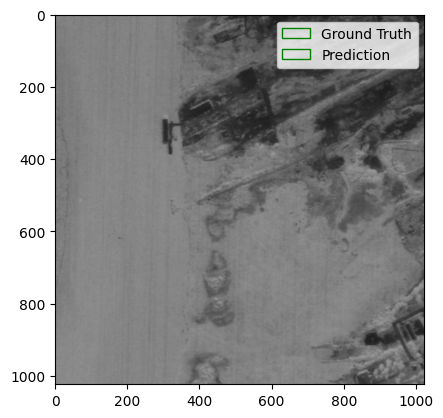

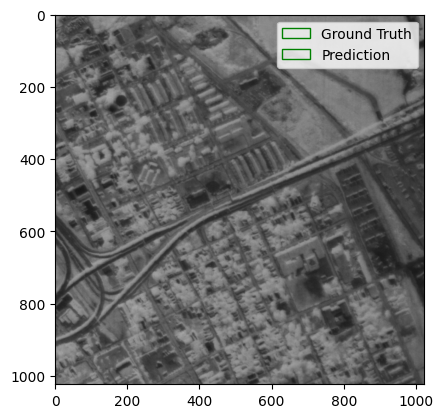

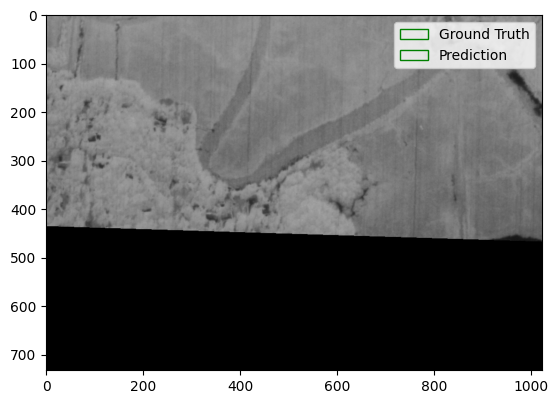

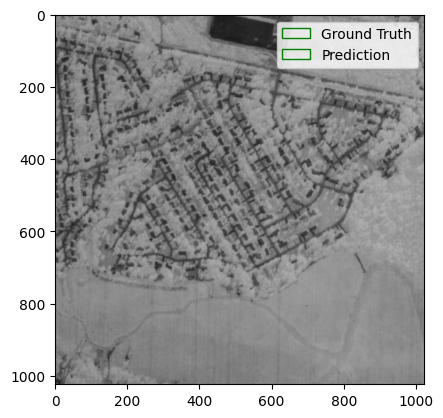

In [ ]:
def plot_predictions(images, targets, predictions):
    for i, image in enumerate(images):
        fig, ax = plt.subplots(1)

        # Convert tensor image to numpy array for plotting
        image_np = F.to_pil_image(image)
        ax.imshow(image_np)

        # Plot ground-truth bounding boxes in green
        for box in targets[i]["boxes"]:
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=1,
                edgecolor="green",
                facecolor="none",
                label="Ground Truth"
            )
            ax.add_patch(rect)

        # Plot predicted bounding boxes in red
        for j, box in enumerate(predictions[i]["boxes"]):
            score = predictions[i]["scores"][j].item()
            if score > 0.5:  # Filter predictions by score threshold (e.g., 0.5)
                x_min, y_min, x_max, y_max = box
                rect = patches.Rectangle(
                    (x_min, y_min),
                    x_max - x_min,
                    y_max - y_min,
                    linewidth=1,
                    edgecolor="red",
                    facecolor="none",
                    label="Prediction"
                )
                ax.add_patch(rect)

        ax.legend(["Ground Truth", "Prediction"])
        plt.show()

# Plot results
plot_predictions(images, targets, predictions)